# A3

### Prepare data from(A1)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- Phase 1 & 2: Load and Clean Data (Same as before) ---
# This part remains the same because the pipeline needs the columns to be in a 
# mostly clean, numeric/string format first.
df_raw = pd.read_csv('/ait/ML/A3/data/Cars.csv')
df = df_raw.copy()
df = df[~df['fuel'].isin(['CNG', 'LPG'])]
owner_map = {"First Owner": 1, "Second Owner": 2, "Third Owner": 3, "Fourth & Above Owner": 4, "Test Drive Car": 5}
df['owner'] = df['owner'].map(owner_map)
df['mileage'] = pd.to_numeric(df['mileage'].str.split().str[0], errors='coerce')
df['engine'] = pd.to_numeric(df['engine'].str.split().str[0], errors='coerce')
df['max_power'] = pd.to_numeric(df['max_power'].str.split().str[0], errors='coerce')
df['brand'] = df['name'].str.split().str[0]
df = df.drop(columns=['torque'])
df = df[df['owner'] != 5]
df = df.reset_index(drop=True)

print("✅ Phase 1 & 2: Initial data cleaning complete.")


# --- Phase 3: Prepare Data with the ColumnTransformer Pipeline ---

# Step 3.1: Create the target variable
# Using 'duplicates=drop' to handle potential issues with qcut if bin edges are not unique
df['price_category'] = pd.qcut(df['selling_price'], q=4, labels=False, duplicates='drop')

# Step 3.2: Define all features that the pipeline will use
# These MUST match the columns listed in your preproc object
cat_features = ["fuel", "seller_type", "transmission", "brand"]
num_features = ["engine", "max_power", "mileage", "seats", "year", "km_driven", "owner"]
all_features = cat_features + num_features

X = df[all_features]
y = df['price_category']

# Step 3.3: Split data into training and testing sets FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✅ Data split complete. X_train shape: {X_train.shape}")

# Step 3.4: Define and Fit the Preprocessing Pipeline
# This is the exact ColumnTransformer you provided
preproc = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False is easier to inspect
    ]), cat_features),
    ("num_median", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), ["engine", "max_power"]),
    ("num_mean", Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ]), ["mileage"]),
    ("num_mode", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("scale", StandardScaler())
    ]), ["seats"]),
    ("num_pass", Pipeline([
        ("scale", StandardScaler())
    ]), ["year", "km_driven", "owner"]),
], remainder='passthrough') # 'passthrough' is good practice

# FIT the pipeline ONLY on the training data
preproc.fit(X_train)
print("✅ Pipeline fitted successfully on X_train.")

# TRANSFORM both the training and test data
X_train_processed = preproc.transform(X_train)
X_test_processed = preproc.transform(X_test)
print("✅ X_train and X_test transformed.")

# Let's check the result
print(f"\nOriginal number of features: {X_train.shape[1]}")
print(f"Shape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed test data:  {X_test_processed.shape}")

✅ Phase 1 & 2: Initial data cleaning complete.
✅ Data split complete. X_train shape: (6422, 11)
✅ Pipeline fitted successfully on X_train.
✅ X_train and X_test transformed.

Original number of features: 11
Shape of processed training data: (6422, 45)
Shape of processed test data:  (1606, 45)


In [8]:
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,price_category
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,Maruti,1
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,Skoda,1
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,Honda,0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0,Hyundai,0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0,Maruti,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8023,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,1,18.50,1197.0,82.85,5.0,Hyundai,1
8024,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,4,16.80,1493.0,110.00,5.0,Hyundai,0
8025,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,1,19.30,1248.0,73.90,5.0,Maruti,1
8026,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,1,23.57,1396.0,70.00,5.0,Tata,1


In [10]:
import numpy as np
from sklearn.metrics import classification_report

def calculate_full_classification_report(y_true, y_pred):
    """
    Calculates and prints a full classification report including
    per-class, macro avg, and weighted avg metrics.
    """
    print("--- From-Scratch Classification Report ---")
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    classes = sorted(np.unique(y_true))
    
    # --- Per-class metrics ---
    per_class_precision = []
    per_class_recall = []
    per_class_f1 = []
    per_class_support = []

    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        support = np.sum(y_true == c)
        
        per_class_precision.append(precision)
        per_class_recall.append(recall)
        per_class_f1.append(f1)
        per_class_support.append(support)
        
        print(f"Class {c}: P={precision:.2f}, R={recall:.2f}, F1={f1:.2f}, Support={support}")

    # --- Averages ---
    total_samples = np.sum(per_class_support)
    
    # Macro averages (simple mean)
    macro_avg_p = np.mean(per_class_precision)
    macro_avg_r = np.mean(per_class_recall)
    macro_avg_f1 = np.mean(per_class_f1)
    
    # Weighted averages
    weighted_avg_p = np.sum(np.array(per_class_precision) * np.array(per_class_support)) / total_samples
    weighted_avg_r = np.sum(np.array(per_class_recall) * np.array(per_class_support)) / total_samples
    weighted_avg_f1 = np.sum(np.array(per_class_f1) * np.array(per_class_support)) / total_samples
    
    # Overall accuracy
    accuracy = np.sum(y_true == y_pred) / total_samples

    print("-" * 40)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Avg: P={macro_avg_p:.2f}, R={macro_avg_r:.2f}, F1={macro_avg_f1:.2f}")
    print(f"Weighted Avg: P={weighted_avg_p:.2f}, R={weighted_avg_r:.2f}, F1={weighted_avg_f1:.2f}")
    print("-" * 40)


In [ ]:
import numpy as np

class LogisticRegression:
    """
    A from-scratch implementation of Multinomial Logistic Regression 
    using batch gradient descent.
    """
    def __init__(self, learning_rate=0.1, n_iterations=1000):
        # Step 1: Initialize hyperparameters
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _one_hot(self, y, n_classes):
        # Step 2: Convert target labels to one-hot encoding
        # e.g., for 4 classes, label '2' becomes [0, 0, 1, 0]
        ohe = np.zeros((len(y), n_classes))
        ohe[np.arange(len(y)), y] = 1
        return ohe

    def softmax(self, z):
        # Step 3: Implement the softmax function
        # The subtraction of max(z) is a trick for numerical stability
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        # Step 4: The training method (Gradient Descent)
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Initialize weights and bias to zeros
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)
        
        # Convert y to one-hot format for loss calculation
        y_ohe = self._one_hot(y, n_classes)
        
        # Main training loop
        for i in range(self.n_iterations):
            # 1. Calculate raw model scores (logits)
            z = X @ self.weights + self.bias
            
            # 2. Convert scores to probabilities (forward pass)
            y_hat = self.softmax(z)
            
            # 3. Calculate the gradient
            # This is the key formula from the lecture/notebook
            gradient = (1 / n_samples) * (X.T @ (y_hat - y_ohe))
            
            # 4. Update the weights
            self.weights -= self.learning_rate * gradient
            
            # (Optional) We could add a step to calculate and store the loss here
            if (i % 100 == 0):
                loss = -np.mean(np.sum(y_ohe * np.log(y_hat + 1e-8), axis=1))
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def predict(self, X):
        # Step 5: The prediction method
        z = X @ self.weights + self.bias
        y_hat = self.softmax(z)
        
        # Return the class with the highest probability
        return np.argmax(y_hat, axis=1)


# --- How to use it with our data ---

# 1. Instantiate the model
# Remember X_train_processed and y_train from our data prep step
model = LogisticRegression(learning_rate=0.1, n_iterations=500)

# 2. Train the model
# NOTE: The 'y_train' must be a NumPy array for this to work correctly
model.fit(X_train_processed, y_train.to_numpy())

# 3. Make predictions on the test set
predictions = model.predict(X_test_processed)

# 4. Evaluate the predictions
# We can use the metrics function we wrote earlier!
print("\n--- Evaluating our from-scratch model ---")
calculate_full_classification_report(y_test.to_numpy(), predictions)

Iteration 0, Loss: 1.3863
Iteration 100, Loss: 0.8513
Iteration 200, Loss: 0.7798
Iteration 300, Loss: 0.7426
Iteration 400, Loss: 0.7184

--- Evaluating our from-scratch model ---
--- From-Scratch Classification Report ---
Class 0: P=0.86, R=0.85, F1=0.85, Support=410
Class 1: P=0.64, R=0.67, F1=0.65, Support=409
Class 2: P=0.60, R=0.57, F1=0.58, Support=389
Class 3: P=0.77, R=0.78, F1=0.78, Support=398
----------------------------------------
Accuracy: 0.7192
Macro Avg: P=0.72, R=0.72, F1=0.72
Weighted Avg: P=0.72, R=0.72, F1=0.72
----------------------------------------


In [12]:
# --- Mockup Data Example ---
y_true_mock = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 0]
y_pred_mock = [0, 2, 2, 3, 0, 1, 1, 3, 0, 0, 0]

# 1. Run your from-scratch function
print("--- My From-Scratch Report ---")
calculate_full_classification_report(y_true_mock, y_pred_mock)

print("\n" + "="*50 + "\n") # Separator

# 2. Run the scikit-learn function for comparison
from sklearn.metrics import classification_report
print("--- Scikit-learn's Report ---")
print(classification_report(y_true_mock, y_pred_mock))

--- My From-Scratch Report ---
--- From-Scratch Classification Report ---
Class 0: P=0.80, R=1.00, F1=0.89, Support=4
Class 1: P=0.50, R=0.33, F1=0.40, Support=3
Class 2: P=0.50, R=0.50, F1=0.50, Support=2
Class 3: P=1.00, R=1.00, F1=1.00, Support=2
----------------------------------------
Accuracy: 0.7273
Macro Avg: P=0.70, R=0.71, F1=0.70
Weighted Avg: P=0.70, R=0.73, F1=0.71
----------------------------------------


--- Scikit-learn's Report ---
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.50      0.33      0.40         3
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         2

    accuracy                           0.73        11
   macro avg       0.70      0.71      0.70        11
weighted avg       0.70      0.73      0.71        11



### Task 1: Validation and Conceptual Questions

#### Comparison with Scikit-learn

To validate our from-scratch metrics function, we compare its output directly against the standard `sklearn.metrics.classification_report`. We use the same set of mockup true labels and predictions for both functions to ensure a fair comparison.

**Analysis:**
The output from the code cell above shows that the calculated values for per-class **precision**, **recall**, **f1-score**, as well as the **macro average** and **weighted average** from our custom `calculate_full_classification_report` function are identical to those produced by scikit-learn. This comparison validates the correctness of our from-scratch implementation.

---

#### Definition of "Support"

In the context of a classification report, **support** refers to the **number of actual occurrences of a class in the true dataset** (`y_true`).

It is a crucial metric because it provides context for the performance scores. A high F1-score is more reliable for a class with a large support (many samples) than for a class with very small support. It helps us understand the trustworthiness of the metrics for each class and is a quick way to identify class imbalance.

In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt

class LogisticRegression:
    """
    A from-scratch implementation of Multinomial Logistic Regression.
    
    Features:
    - L2 (Ridge) Regularization
    - Batch, Mini-Batch, and Stochastic Gradient Descent
    - Loss history tracking for diagnostics
    """
    def __init__(self, learning_rate=0.1, n_iterations=100, lmbda=0.01, batch_size=32):
        """
        Initializes the model.
        
        Args:
            learning_rate (float): Step size for gradient descent.
            n_iterations (int): Number of epochs (full passes over the training data).
            lmbda (float): Regularization strength (lambda).
            batch_size (int): Number of samples per batch.
                - If batch_size == n_samples -> Batch Gradient Descent
                - If batch_size == 1 -> Stochastic Gradient Descent (SGD)
                - Otherwise -> Mini-Batch Gradient Descent
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lmbda = lmbda
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _one_hot(self, y, n_classes):
        """Helper function to convert labels to one-hot encoding."""
        ohe = np.zeros((len(y), n_classes))
        ohe[np.arange(len(y)), y] = 1
        return ohe

    def softmax(self, z):
        """The softmax activation function for converting scores to probabilities."""
        # Subtracting max(z) is a trick for numerical stability to prevent overflow
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        """Trains the model using the provided data."""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Initialize weights and bias to zeros
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)
        
        # The main loop now iterates over epochs
        for epoch in range(self.n_iterations):
            # --- CRITICAL STEP: Shuffle the data at the start of each epoch ---
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            # --- Loop over mini-batches ---
            n_batches = math.ceil(n_samples / self.batch_size)
            for i in range(n_batches):
                # Get the current mini-batch
                start = i * self.batch_size
                end = min(start + self.batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                # --- The logic below uses the BATCH data for one update ---
                n_batch_samples = X_batch.shape[0]
                if n_batch_samples == 0: continue
                
                y_ohe_batch = self._one_hot(y_batch, n_classes)

                # 1. Calculate scores (logits) and probabilities
                z = X_batch @ self.weights + self.bias
                y_hat = self.softmax(z)
                
                # 2. Calculate gradient with L2 penalty
                original_gradient = (1 / n_batch_samples) * (X_batch.T @ (y_hat - y_ohe_batch))
                l2_penalty = (self.lmbda / n_batch_samples) * self.weights
                gradient = original_gradient + l2_penalty
                
                # 3. Update weights
                self.weights -= self.learning_rate * gradient

            # --- Calculate and store loss on the FULL dataset at the end of each epoch ---
            full_z = X @ self.weights + self.bias
            full_y_hat = self.softmax(full_z)
            full_y_ohe = self._one_hot(y, n_classes)
            
            cross_entropy_loss = -np.mean(np.sum(full_y_ohe * np.log(full_y_hat + 1e-8), axis=1))
            l2_loss_penalty = (self.lmbda / (2 * n_samples)) * np.sum(self.weights**2)
            total_loss = cross_entropy_loss + l2_loss_penalty
            self.loss_history.append(total_loss)
            
            if (epoch % 10 == 0) or (epoch == self.n_iterations - 1):
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    def predict(self, X):
        """Makes predictions for new data."""
        z = X @ self.weights + self.bias
        y_hat = self.softmax(z)
        return np.argmax(y_hat, axis=1)

Epoch 0, Loss: 0.8513
Epoch 10, Loss: 0.6505
Epoch 20, Loss: 0.6189
Epoch 30, Loss: 0.6058
Epoch 40, Loss: 0.5990
Epoch 50, Loss: 0.5934


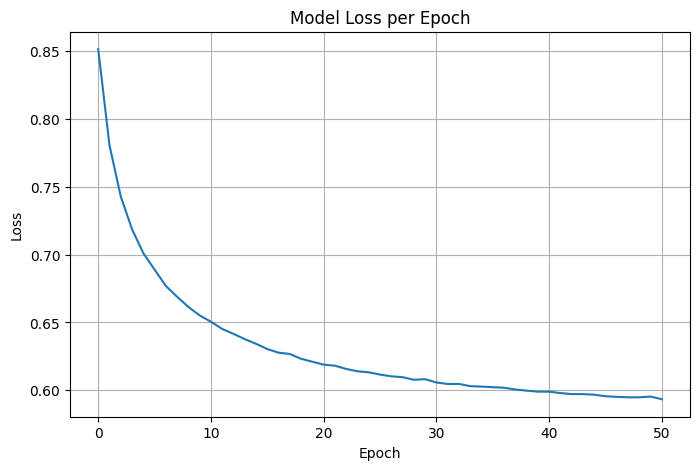


--- Final Model Performance ---
--- From-Scratch Classification Report ---
Class 0: P=0.88, R=0.85, F1=0.86, Support=410
Class 1: P=0.68, R=0.71, F1=0.70, Support=409
Class 2: P=0.64, R=0.65, F1=0.64, Support=389
Class 3: P=0.83, R=0.81, F1=0.82, Support=398
----------------------------------------
Accuracy: 0.7559
Macro Avg: P=0.76, R=0.75, F1=0.76
Weighted Avg: P=0.76, R=0.76, F1=0.76
----------------------------------------


In [24]:
# 1. Instantiate the model with desired hyperparameters
model = LogisticRegression(
    learning_rate=0.1, 
    n_iterations=51,  # Number of epochs
    lmbda=0.01,       # Regularization strength
    batch_size=64     # Mini-batch size
)

# 2. Train the model (it will print the loss at the end of each epoch)
# Note: y_train must be a NumPy array
model.fit(X_train_processed, y_train.to_numpy())

# 3. Plot the loss history to diagnose training
plt.figure(figsize=(8, 5))
plt.plot(model.loss_history)
plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 4. Make predictions and evaluate
predictions = model.predict(X_test_processed)
print("\n--- Final Model Performance ---")
calculate_full_classification_report(y_test.to_numpy(), predictions)

In [27]:
from sklearn.metrics import f1_score
import time
import random

# 1. Define the same expanded grid of possibilities
param_grid_expanded = {
    'learning_rate': [0.1, 0.05, 0.01],
    'lmbda': [0.001, 0.01, 0.1, 1.0],
    'batch_size': [32, 64]
}

# 2. Set the number of random combinations you want to try
# We'll try 8 random models instead of all 24.
n_iter = 8

# 3. Prepare to track the best results
best_score = -1
best_params = {}
results = []

print(f"--- Starting Random Search (testing {n_iter} random combinations) ---")
start_time = time.time()

# 4. Loop for a fixed number of iterations
for i in range(n_iter):
    
    # --- Pick a RANDOM value for each hyperparameter ---
    lr = random.choice(param_grid_expanded['learning_rate'])
    lmbda = random.choice(param_grid_expanded['lmbda'])
    bs = random.choice(param_grid_expanded['batch_size'])
    
    current_params = {'lr': lr, 'lmbda': lmbda, 'batch_size': bs}
    print(f"\n({i+1}/{n_iter}) Training with random params: {current_params}")
    
    # Instantiate and train the model
    model = LogisticRegression(
        learning_rate=lr,
        n_iterations=101,
        lmbda=lmbda,
        batch_size=bs
    )
    model.fit(X_train_processed, y_train.to_numpy())
    
    # Evaluate the model
    predictions = model.predict(X_test_processed)
    score = f1_score(y_test, predictions, average='weighted')
    
    print(f"-> Weighted F1-Score: {score:.4f}")
    results.append({'params': current_params, 'score': score})
    
    # Check if this is the best model so far
    if score > best_score:
        best_score = score
        best_params = current_params

end_time = time.time()
print(f"\n--- Random Search Complete in {end_time - start_time:.2f} seconds ---")
print(f"🏆 Best Weighted F1-Score: {best_score:.4f}")
print(f"🚀 Best Hyperparameters: {best_params}")

--- Starting Random Search (testing 8 random combinations) ---

(1/8) Training with random params: {'lr': 0.05, 'lmbda': 0.1, 'batch_size': 32}
Epoch 0, Loss: 0.8550
Epoch 10, Loss: 0.6683
Epoch 20, Loss: 0.6458
Epoch 30, Loss: 0.6389
Epoch 40, Loss: 0.6363
Epoch 50, Loss: 0.6345
Epoch 60, Loss: 0.6344
Epoch 70, Loss: 0.6333
Epoch 80, Loss: 0.6327
Epoch 90, Loss: 0.6328
Epoch 100, Loss: 0.6326
-> Weighted F1-Score: 0.7455

(2/8) Training with random params: {'lr': 0.01, 'lmbda': 0.001, 'batch_size': 32}
Epoch 0, Loss: 1.0543
Epoch 10, Loss: 0.7707
Epoch 20, Loss: 0.7143
Epoch 30, Loss: 0.6851
Epoch 40, Loss: 0.6664
Epoch 50, Loss: 0.6531
Epoch 60, Loss: 0.6431
Epoch 70, Loss: 0.6353
Epoch 80, Loss: 0.6290
Epoch 90, Loss: 0.6238
Epoch 100, Loss: 0.6194
-> Weighted F1-Score: 0.7456

(3/8) Training with random params: {'lr': 0.05, 'lmbda': 0.001, 'batch_size': 32}
Epoch 0, Loss: 0.8524
Epoch 10, Loss: 0.6490
Epoch 20, Loss: 0.6186
Epoch 30, Loss: 0.6053
Epoch 40, Loss: 0.5971
Epoch 50, Lo

In [34]:
import os
import mlflow
import random
import time
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin


# --- Make sure your LogisticRegression class is in a file named 'model.py' ---
# If you get an ImportError, it means the file is not in the same directory.
try:
    from model import LogisticRegression
except ImportError:
    print("❌ Error: 'model.py' not found. Please ensure it's in the same directory.")
    # You can define a dummy class to prevent the script from crashing immediately
    class LogisticRegression: pass 

# --- A wrapper to make our from-scratch model compatible with mlflow.sklearn ---
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.1, n_iterations=100, lmbda=0.01, batch_size=32):
        # We instantiate our actual model inside the wrapper
        self.model = LogisticRegression(learning_rate, n_iterations, lmbda, batch_size)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


# --- 1. SET CREDENTIALS AND CONFIGURE MLFLOW (same as before) ---
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin' 
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")
mlflow.set_experiment("st126055-a3") 

# --- 2. DEFINE YOUR FULL HYPERPARAMETER GRID ---
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'lmbda': [0.001, 0.01, 0.1, 1.0],
    'batch_size': [1, 32, 64, 128]
}

total_runs = len(param_grid['learning_rate']) * len(param_grid['lmbda']) * len(param_grid['batch_size'])
print(f"--- Starting GRID Search: Logging all {total_runs} runs to MLflow ---")
start_time = time.time()
run_count = 0

# --- USE NESTED LOOPS FOR GRID SEARCH ---
for lr in param_grid['learning_rate']:
    for lmbda in param_grid['lmbda']:
        for bs in param_grid['batch_size']:
            run_count += 1
            current_params = {'learning_rate': lr, 'lmbda': lmbda, 'batch_size': bs}
            run_name = f"run_{run_count}_lr={lr}_lambda={lmbda}_bs={bs}"
            
            with mlflow.start_run(run_name=run_name):
                print(f"\n({run_count}/{total_runs}) Logging run: '{run_name}'")
                mlflow.log_params(current_params)
                
                # Train the model
                wrapped_model = SklearnWrapper(
                    learning_rate=lr,
                    n_iterations=101,
                    lmbda=lmbda,
                    batch_size=bs
                )
                wrapped_model.fit(X_train_processed, y_train.to_numpy())
                
                # --- LOG THE LOSS CURVE (already implemented) ---
                for epoch, loss in enumerate(wrapped_model.model.loss_history):
                    mlflow.log_metric("epoch_loss", loss, step=epoch)
                
                # --- CALCULATE AND LOG ALL FINAL METRICS ---
                predictions = wrapped_model.predict(X_test_processed)
                
                # Calculate all the scores
                accuracy = accuracy_score(y_test, predictions)
                precision = precision_score(y_test, predictions, average='weighted')
                recall = recall_score(y_test, predictions, average='weighted')
                f1 = f1_score(y_test, predictions, average='weighted')
                
                print(f"-> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                
                # Log each metric to MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision_weighted", precision)
                mlflow.log_metric("recall_weighted", recall)
                mlflow.log_metric("f1_score_weighted", f1)
                
                # LOG MODEL (same as before)
                mlflow.sklearn.log_model(wrapped_model, artifact_path="model")

end_time = time.time()
print(f"\n--- Grid Search finished in {end_time - start_time:.2f} seconds ---")

--- Starting GRID Search: Logging all 48 runs to MLflow ---

(1/48) Logging run: 'run_1_lr=0.1_lambda=0.001_bs=1'
Epoch 0, Loss: 0.6824
Epoch 10, Loss: 0.6683
Epoch 20, Loss: 0.6742
Epoch 30, Loss: 0.6592
Epoch 40, Loss: 0.6426
Epoch 50, Loss: 0.8149
Epoch 60, Loss: 0.7001
Epoch 70, Loss: 0.6546
Epoch 80, Loss: 0.8341
Epoch 90, Loss: 0.6491
Epoch 100, Loss: 0.6909
-> Accuracy: 0.7111, Precision: 0.7115, Recall: 0.7111, F1: 0.7103


2025/10/04 03:35:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:35:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_1_lr=0.1_lambda=0.001_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/c856912f9dc046a49def9e8d10165547
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(2/48) Logging run: 'run_2_lr=0.1_lambda=0.001_bs=32'
Epoch 0, Loss: 0.7828
Epoch 10, Loss: 0.6193
Epoch 20, Loss: 0.5972
Epoch 30, Loss: 0.5919
Epoch 40, Loss: 0.5848
Epoch 50, Loss: 0.5830
Epoch 60, Loss: 0.5818
Epoch 70, Loss: 0.5811
Epoch 80, Loss: 0.5789
Epoch 90, Loss: 0.5787
Epoch 100, Loss: 0.5829
-> Accuracy: 0.7516, Precision: 0.7566, Recall: 0.7516, F1: 0.7534


2025/10/04 03:36:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_2_lr=0.1_lambda=0.001_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/a4563931128c47aa874edb6f661fa63b
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(3/48) Logging run: 'run_3_lr=0.1_lambda=0.001_bs=64'
Epoch 0, Loss: 0.8522
Epoch 10, Loss: 0.6487
Epoch 20, Loss: 0.6181
Epoch 30, Loss: 0.6040
Epoch 40, Loss: 0.5973
Epoch 50, Loss: 0.5921
Epoch 60, Loss: 0.5883
Epoch 70, Loss: 0.5873
Epoch 80, Loss: 0.5853
Epoch 90, Loss: 0.5831
Epoch 100, Loss: 0.5826
-> Accuracy: 0.7547, Precision: 0.7586, Recall: 0.7547, F1: 0.7562


2025/10/04 03:37:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:38:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_3_lr=0.1_lambda=0.001_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/991eb69e70694abd840f1b9f0623ccd1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(4/48) Logging run: 'run_4_lr=0.1_lambda=0.001_bs=128'
Epoch 0, Loss: 0.9309
Epoch 10, Loss: 0.6924
Epoch 20, Loss: 0.6504
Epoch 30, Loss: 0.6307
Epoch 40, Loss: 0.6183
Epoch 50, Loss: 0.6104
Epoch 60, Loss: 0.6044
Epoch 70, Loss: 0.6011
Epoch 80, Loss: 0.5971
Epoch 90, Loss: 0.5937
Epoch 100, Loss: 0.5917
-> Accuracy: 0.7565, Precision: 0.7586, Recall: 0.7565, F1: 0.7574


2025/10/04 03:39:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:39:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_4_lr=0.1_lambda=0.001_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/6a8344931720420e877eae669defaa9a
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(5/48) Logging run: 'run_5_lr=0.1_lambda=0.01_bs=1'
Epoch 0, Loss: 0.7981
Epoch 10, Loss: 0.7797
Epoch 20, Loss: 0.7870
Epoch 30, Loss: 0.7671
Epoch 40, Loss: 0.7744
Epoch 50, Loss: 0.8563
Epoch 60, Loss: 0.7787
Epoch 70, Loss: 0.8108
Epoch 80, Loss: 0.7922
Epoch 90, Loss: 0.7887
Epoch 100, Loss: 0.8573
-> Accuracy: 0.6202, Precision: 0.6542, Recall: 0.6202, F1: 0.5845


2025/10/04 03:40:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:40:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_5_lr=0.1_lambda=0.01_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/db7161eb5a044d3cb8a47c01c42c5ce5
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(6/48) Logging run: 'run_6_lr=0.1_lambda=0.01_bs=32'
Epoch 0, Loss: 0.7836
Epoch 10, Loss: 0.6190
Epoch 20, Loss: 0.6002
Epoch 30, Loss: 0.5931
Epoch 40, Loss: 0.5883
Epoch 50, Loss: 0.5889
Epoch 60, Loss: 0.5861
Epoch 70, Loss: 0.5847
Epoch 80, Loss: 0.5835
Epoch 90, Loss: 0.5831
Epoch 100, Loss: 0.5848
-> Accuracy: 0.7528, Precision: 0.7579, Recall: 0.7528, F1: 0.7549


2025/10/04 03:41:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:41:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_6_lr=0.1_lambda=0.01_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/fc351e82cfc248b09b867660bdbe8134
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(7/48) Logging run: 'run_7_lr=0.1_lambda=0.01_bs=64'
Epoch 0, Loss: 0.8512
Epoch 10, Loss: 0.6497
Epoch 20, Loss: 0.6195
Epoch 30, Loss: 0.6071
Epoch 40, Loss: 0.5983
Epoch 50, Loss: 0.5936
Epoch 60, Loss: 0.5905
Epoch 70, Loss: 0.5880
Epoch 80, Loss: 0.5869
Epoch 90, Loss: 0.5855
Epoch 100, Loss: 0.5838
-> Accuracy: 0.7584, Precision: 0.7630, Recall: 0.7584, F1: 0.7603


2025/10/04 03:42:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:42:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_7_lr=0.1_lambda=0.01_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/8da3c17a7c1a4bcc8757d7aa8c27eedc
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(8/48) Logging run: 'run_8_lr=0.1_lambda=0.01_bs=128'
Epoch 0, Loss: 0.9309
Epoch 10, Loss: 0.6934
Epoch 20, Loss: 0.6514
Epoch 30, Loss: 0.6308
Epoch 40, Loss: 0.6193
Epoch 50, Loss: 0.6107
Epoch 60, Loss: 0.6051
Epoch 70, Loss: 0.6011
Epoch 80, Loss: 0.5979
Epoch 90, Loss: 0.5948
Epoch 100, Loss: 0.5929
-> Accuracy: 0.7553, Precision: 0.7612, Recall: 0.7553, F1: 0.7576


2025/10/04 03:43:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:43:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_8_lr=0.1_lambda=0.01_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/458a5298638441c595c505f1ba6916be
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(9/48) Logging run: 'run_9_lr=0.1_lambda=0.1_bs=1'
Epoch 0, Loss: 1.0795
Epoch 10, Loss: 0.9552
Epoch 20, Loss: 0.9738
Epoch 30, Loss: 0.9909
Epoch 40, Loss: 0.9938
Epoch 50, Loss: 0.9512
Epoch 60, Loss: 0.9843
Epoch 70, Loss: 0.9989
Epoch 80, Loss: 1.0126
Epoch 90, Loss: 0.9950
Epoch 100, Loss: 0.9855
-> Accuracy: 0.5710, Precision: 0.5549, Recall: 0.5710, F1: 0.5575


2025/10/04 03:44:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:45:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_9_lr=0.1_lambda=0.1_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/0d9981be26094ad6ba9ca0e487526752
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(10/48) Logging run: 'run_10_lr=0.1_lambda=0.1_bs=32'
Epoch 0, Loss: 0.7886
Epoch 10, Loss: 0.6456
Epoch 20, Loss: 0.6363
Epoch 30, Loss: 0.6344
Epoch 40, Loss: 0.6339
Epoch 50, Loss: 0.6339
Epoch 60, Loss: 0.6341
Epoch 70, Loss: 0.6331
Epoch 80, Loss: 0.6331
Epoch 90, Loss: 0.6337
Epoch 100, Loss: 0.6337
-> Accuracy: 0.7484, Precision: 0.7575, Recall: 0.7484, F1: 0.7518


2025/10/04 03:46:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:46:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_10_lr=0.1_lambda=0.1_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/da4b6dfe53af4afca34b62a3dd285d54
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(11/48) Logging run: 'run_11_lr=0.1_lambda=0.1_bs=64'
Epoch 0, Loss: 0.8528
Epoch 10, Loss: 0.6592
Epoch 20, Loss: 0.6329
Epoch 30, Loss: 0.6218
Epoch 40, Loss: 0.6171
Epoch 50, Loss: 0.6136
Epoch 60, Loss: 0.6126
Epoch 70, Loss: 0.6104
Epoch 80, Loss: 0.6104
Epoch 90, Loss: 0.6092
Epoch 100, Loss: 0.6088
-> Accuracy: 0.7559, Precision: 0.7583, Recall: 0.7559, F1: 0.7570


2025/10/04 03:47:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:47:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_11_lr=0.1_lambda=0.1_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/0741ffb7e79d4499b8ab7aa4efcd8476
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(12/48) Logging run: 'run_12_lr=0.1_lambda=0.1_bs=128'
Epoch 0, Loss: 0.9309
Epoch 10, Loss: 0.6959
Epoch 20, Loss: 0.6560
Epoch 30, Loss: 0.6374
Epoch 40, Loss: 0.6264
Epoch 50, Loss: 0.6189
Epoch 60, Loss: 0.6135
Epoch 70, Loss: 0.6099
Epoch 80, Loss: 0.6069
Epoch 90, Loss: 0.6050
Epoch 100, Loss: 0.6029
-> Accuracy: 0.7553, Precision: 0.7593, Recall: 0.7553, F1: 0.7570


2025/10/04 03:48:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:48:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_12_lr=0.1_lambda=0.1_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/f2e9711f8d124c4faa6c4ed3ebe4abc8
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(13/48) Logging run: 'run_13_lr=0.1_lambda=1.0_bs=1'
Epoch 0, Loss: 1.2128
Epoch 10, Loss: 1.2165
Epoch 20, Loss: 1.2421
Epoch 30, Loss: 1.2244
Epoch 40, Loss: 1.2243
Epoch 50, Loss: 1.2384
Epoch 60, Loss: 1.2612
Epoch 70, Loss: 1.1839
Epoch 80, Loss: 1.1955
Epoch 90, Loss: 1.2662
Epoch 100, Loss: 1.2355
-> Accuracy: 0.4489, Precision: 0.4313, Recall: 0.4489, F1: 0.4077


2025/10/04 03:49:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:49:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_13_lr=0.1_lambda=1.0_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/391fc48b6f7842fba3ac72234ebd4ec8
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(14/48) Logging run: 'run_14_lr=0.1_lambda=1.0_bs=32'
Epoch 0, Loss: 0.8318
Epoch 10, Loss: 0.7932
Epoch 20, Loss: 0.7936
Epoch 30, Loss: 0.7942
Epoch 40, Loss: 0.7937
Epoch 50, Loss: 0.7946
Epoch 60, Loss: 0.7949
Epoch 70, Loss: 0.7960
Epoch 80, Loss: 0.7944
Epoch 90, Loss: 0.7948
Epoch 100, Loss: 0.7927
-> Accuracy: 0.6961, Precision: 0.6904, Recall: 0.6961, F1: 0.6913


2025/10/04 03:50:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:50:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_14_lr=0.1_lambda=1.0_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/02616312b4ff4246b7a4f228f0e89424
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(15/48) Logging run: 'run_15_lr=0.1_lambda=1.0_bs=64'
Epoch 0, Loss: 0.8670
Epoch 10, Loss: 0.7377
Epoch 20, Loss: 0.7341
Epoch 30, Loss: 0.7340
Epoch 40, Loss: 0.7344
Epoch 50, Loss: 0.7348
Epoch 60, Loss: 0.7347
Epoch 70, Loss: 0.7351
Epoch 80, Loss: 0.7345
Epoch 90, Loss: 0.7343
Epoch 100, Loss: 0.7344
-> Accuracy: 0.7179, Precision: 0.7127, Recall: 0.7179, F1: 0.7139


2025/10/04 03:51:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_15_lr=0.1_lambda=1.0_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/497b4fd27cfb45858a5a959268f48003
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(16/48) Logging run: 'run_16_lr=0.1_lambda=1.0_bs=128'
Epoch 0, Loss: 0.9338
Epoch 10, Loss: 0.7262
Epoch 20, Loss: 0.7016
Epoch 30, Loss: 0.6945
Epoch 40, Loss: 0.6912
Epoch 50, Loss: 0.6900
Epoch 60, Loss: 0.6900
Epoch 70, Loss: 0.6901
Epoch 80, Loss: 0.6889
Epoch 90, Loss: 0.6894
Epoch 100, Loss: 0.6887
-> Accuracy: 0.7341, Precision: 0.7342, Recall: 0.7341, F1: 0.7338


2025/10/04 03:53:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:53:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_16_lr=0.1_lambda=1.0_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/ec67debfeac34a858466211fb84d4044
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(17/48) Logging run: 'run_17_lr=0.05_lambda=0.001_bs=1'
Epoch 0, Loss: 0.6767
Epoch 10, Loss: 0.6477
Epoch 20, Loss: 0.7130
Epoch 30, Loss: 0.6451
Epoch 40, Loss: 0.6695
Epoch 50, Loss: 0.6401
Epoch 60, Loss: 0.6209
Epoch 70, Loss: 0.6305
Epoch 80, Loss: 0.6368
Epoch 90, Loss: 0.6679
Epoch 100, Loss: 0.6140
-> Accuracy: 0.7360, Precision: 0.7446, Recall: 0.7360, F1: 0.7363


2025/10/04 03:54:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:54:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_17_lr=0.05_lambda=0.001_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/3a0cd4c76ff047cab8e9cd4448b71188
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(18/48) Logging run: 'run_18_lr=0.05_lambda=0.001_bs=32'
Epoch 0, Loss: 0.8517
Epoch 10, Loss: 0.6492
Epoch 20, Loss: 0.6185
Epoch 30, Loss: 0.6046
Epoch 40, Loss: 0.5967
Epoch 50, Loss: 0.5931
Epoch 60, Loss: 0.5887
Epoch 70, Loss: 0.5864
Epoch 80, Loss: 0.5848
Epoch 90, Loss: 0.5838
Epoch 100, Loss: 0.5825
-> Accuracy: 0.7565, Precision: 0.7625, Recall: 0.7565, F1: 0.7589


2025/10/04 03:55:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:55:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_18_lr=0.05_lambda=0.001_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/f70b924fb3af4859a3f4d8a9bfadae4b
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(19/48) Logging run: 'run_19_lr=0.05_lambda=0.001_bs=64'
Epoch 0, Loss: 0.9321
Epoch 10, Loss: 0.6935
Epoch 20, Loss: 0.6512
Epoch 30, Loss: 0.6311
Epoch 40, Loss: 0.6190
Epoch 50, Loss: 0.6108
Epoch 60, Loss: 0.6048
Epoch 70, Loss: 0.6002
Epoch 80, Loss: 0.5967
Epoch 90, Loss: 0.5942
Epoch 100, Loss: 0.5918
-> Accuracy: 0.7534, Precision: 0.7581, Recall: 0.7534, F1: 0.7554


2025/10/04 03:56:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:56:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_19_lr=0.05_lambda=0.001_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/8d04f9cf75de40f4b169dd0418a68455
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(20/48) Logging run: 'run_20_lr=0.05_lambda=0.001_bs=128'
Epoch 0, Loss: 1.0216
Epoch 10, Loss: 0.7487
Epoch 20, Loss: 0.6959
Epoch 30, Loss: 0.6689
Epoch 40, Loss: 0.6518
Epoch 50, Loss: 0.6400
Epoch 60, Loss: 0.6310
Epoch 70, Loss: 0.6241
Epoch 80, Loss: 0.6186
Epoch 90, Loss: 0.6140
Epoch 100, Loss: 0.6103
-> Accuracy: 0.7547, Precision: 0.7567, Recall: 0.7547, F1: 0.7555


2025/10/04 03:57:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:57:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_20_lr=0.05_lambda=0.001_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/d134e782294f490a9df16e79f206f66f
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(21/48) Logging run: 'run_21_lr=0.05_lambda=0.01_bs=1'
Epoch 0, Loss: 0.7572
Epoch 10, Loss: 0.7380
Epoch 20, Loss: 0.7651
Epoch 30, Loss: 0.7347
Epoch 40, Loss: 0.7337
Epoch 50, Loss: 0.7199
Epoch 60, Loss: 0.7612
Epoch 70, Loss: 0.8752
Epoch 80, Loss: 0.7355
Epoch 90, Loss: 0.7472
Epoch 100, Loss: 0.7250
-> Accuracy: 0.7067, Precision: 0.7010, Recall: 0.7067, F1: 0.6977


2025/10/04 03:58:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 03:59:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_21_lr=0.05_lambda=0.01_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/2e777fab7d344a74860f0eb1fa91afda
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(22/48) Logging run: 'run_22_lr=0.05_lambda=0.01_bs=32'
Epoch 0, Loss: 0.8523
Epoch 10, Loss: 0.6518
Epoch 20, Loss: 0.6207
Epoch 30, Loss: 0.6073
Epoch 40, Loss: 0.6002
Epoch 50, Loss: 0.5957
Epoch 60, Loss: 0.5931
Epoch 70, Loss: 0.5904
Epoch 80, Loss: 0.5900
Epoch 90, Loss: 0.5876
Epoch 100, Loss: 0.5869
-> Accuracy: 0.7597, Precision: 0.7654, Recall: 0.7597, F1: 0.7618


2025/10/04 04:00:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:00:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_22_lr=0.05_lambda=0.01_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/a693121e7645409193621f9bc4a3d21c
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(23/48) Logging run: 'run_23_lr=0.05_lambda=0.01_bs=64'
Epoch 0, Loss: 0.9322
Epoch 10, Loss: 0.6942
Epoch 20, Loss: 0.6520
Epoch 30, Loss: 0.6318
Epoch 40, Loss: 0.6198
Epoch 50, Loss: 0.6118
Epoch 60, Loss: 0.6059
Epoch 70, Loss: 0.6020
Epoch 80, Loss: 0.5982
Epoch 90, Loss: 0.5956
Epoch 100, Loss: 0.5936
-> Accuracy: 0.7516, Precision: 0.7545, Recall: 0.7516, F1: 0.7527


2025/10/04 04:01:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:01:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_23_lr=0.05_lambda=0.01_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/4565943ad0b548ba9e40bbbb02ad5935
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(24/48) Logging run: 'run_24_lr=0.05_lambda=0.01_bs=128'
Epoch 0, Loss: 1.0209
Epoch 10, Loss: 0.7490
Epoch 20, Loss: 0.6963
Epoch 30, Loss: 0.6694
Epoch 40, Loss: 0.6524
Epoch 50, Loss: 0.6406
Epoch 60, Loss: 0.6317
Epoch 70, Loss: 0.6248
Epoch 80, Loss: 0.6193
Epoch 90, Loss: 0.6148
Epoch 100, Loss: 0.6110
-> Accuracy: 0.7503, Precision: 0.7544, Recall: 0.7503, F1: 0.7520


2025/10/04 04:02:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:02:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_24_lr=0.05_lambda=0.01_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/065cb893d34d4cdf9beaca3fa748c4ca
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(25/48) Logging run: 'run_25_lr=0.05_lambda=0.1_bs=1'
Epoch 0, Loss: 0.9579
Epoch 10, Loss: 0.9714
Epoch 20, Loss: 0.9230
Epoch 30, Loss: 0.9339
Epoch 40, Loss: 0.9422
Epoch 50, Loss: 0.9322
Epoch 60, Loss: 1.1033
Epoch 70, Loss: 0.9512
Epoch 80, Loss: 0.9648
Epoch 90, Loss: 0.9816
Epoch 100, Loss: 0.9268
-> Accuracy: 0.5915, Precision: 0.5950, Recall: 0.5915, F1: 0.5691


2025/10/04 04:03:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:03:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_25_lr=0.05_lambda=0.1_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/b9fdc787e25147f2a8089f4362eae30b
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(26/48) Logging run: 'run_26_lr=0.05_lambda=0.1_bs=32'
Epoch 0, Loss: 0.8552
Epoch 10, Loss: 0.6681
Epoch 20, Loss: 0.6461
Epoch 30, Loss: 0.6385
Epoch 40, Loss: 0.6356
Epoch 50, Loss: 0.6340
Epoch 60, Loss: 0.6333
Epoch 70, Loss: 0.6326
Epoch 80, Loss: 0.6325
Epoch 90, Loss: 0.6325
Epoch 100, Loss: 0.6324
-> Accuracy: 0.7547, Precision: 0.7554, Recall: 0.7547, F1: 0.7547


2025/10/04 04:04:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:04:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_26_lr=0.05_lambda=0.1_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/2a2c7880d2a24c98b4c5c8514f784dbc
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(27/48) Logging run: 'run_27_lr=0.05_lambda=0.1_bs=64'
Epoch 0, Loss: 0.9322
Epoch 10, Loss: 0.6993
Epoch 20, Loss: 0.6605
Epoch 30, Loss: 0.6427
Epoch 40, Loss: 0.6327
Epoch 50, Loss: 0.6260
Epoch 60, Loss: 0.6218
Epoch 70, Loss: 0.6185
Epoch 80, Loss: 0.6162
Epoch 90, Loss: 0.6148
Epoch 100, Loss: 0.6133
-> Accuracy: 0.7559, Precision: 0.7579, Recall: 0.7559, F1: 0.7566


2025/10/04 04:05:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:05:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_27_lr=0.05_lambda=0.1_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/80389e91ad9f480a871784dd3c17df18
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(28/48) Logging run: 'run_28_lr=0.05_lambda=0.1_bs=128'
Epoch 0, Loss: 1.0211
Epoch 10, Loss: 0.7506
Epoch 20, Loss: 0.6990
Epoch 30, Loss: 0.6733
Epoch 40, Loss: 0.6569
Epoch 50, Loss: 0.6457
Epoch 60, Loss: 0.6375
Epoch 70, Loss: 0.6312
Epoch 80, Loss: 0.6262
Epoch 90, Loss: 0.6222
Epoch 100, Loss: 0.6189
-> Accuracy: 0.7453, Precision: 0.7489, Recall: 0.7453, F1: 0.7468


2025/10/04 04:07:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:07:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_28_lr=0.05_lambda=0.1_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/347dd711bc37428bbc986ce22a76e6f1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(29/48) Logging run: 'run_29_lr=0.05_lambda=1.0_bs=1'
Epoch 0, Loss: 1.1811
Epoch 10, Loss: 1.1623
Epoch 20, Loss: 1.1941
Epoch 30, Loss: 1.1980
Epoch 40, Loss: 1.1494
Epoch 50, Loss: 1.1940
Epoch 60, Loss: 1.1695
Epoch 70, Loss: 1.2075
Epoch 80, Loss: 1.1951
Epoch 90, Loss: 1.2011
Epoch 100, Loss: 1.2180
-> Accuracy: 0.4222, Precision: 0.4929, Recall: 0.4222, F1: 0.3368


2025/10/04 04:08:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:08:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_29_lr=0.05_lambda=1.0_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/e028800e81d74d07a846b1bce6b23dc2
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(30/48) Logging run: 'run_30_lr=0.05_lambda=1.0_bs=32'
Epoch 0, Loss: 0.8788
Epoch 10, Loss: 0.7936
Epoch 20, Loss: 0.7934
Epoch 30, Loss: 0.7920
Epoch 40, Loss: 0.7928
Epoch 50, Loss: 0.7926
Epoch 60, Loss: 0.7940
Epoch 70, Loss: 0.7924
Epoch 80, Loss: 0.7924
Epoch 90, Loss: 0.7939
Epoch 100, Loss: 0.7935
-> Accuracy: 0.6974, Precision: 0.6890, Recall: 0.6974, F1: 0.6897


2025/10/04 04:09:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:09:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_30_lr=0.05_lambda=1.0_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/3a02942f2866460394915c93dd3774b1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(31/48) Logging run: 'run_31_lr=0.05_lambda=1.0_bs=64'
Epoch 0, Loss: 0.9392
Epoch 10, Loss: 0.7515
Epoch 20, Loss: 0.7374
Epoch 30, Loss: 0.7347
Epoch 40, Loss: 0.7342
Epoch 50, Loss: 0.7336
Epoch 60, Loss: 0.7340
Epoch 70, Loss: 0.7337
Epoch 80, Loss: 0.7336
Epoch 90, Loss: 0.7339
Epoch 100, Loss: 0.7338
-> Accuracy: 0.7210, Precision: 0.7188, Recall: 0.7210, F1: 0.7198


2025/10/04 04:10:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:10:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_31_lr=0.05_lambda=1.0_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/9c2dba462a6a435a8fb932dbac9ae980
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(32/48) Logging run: 'run_32_lr=0.05_lambda=1.0_bs=128'
Epoch 0, Loss: 1.0236
Epoch 10, Loss: 0.7683
Epoch 20, Loss: 0.7279
Epoch 30, Loss: 0.7109
Epoch 40, Loss: 0.7019
Epoch 50, Loss: 0.6970
Epoch 60, Loss: 0.6941
Epoch 70, Loss: 0.6922
Epoch 80, Loss: 0.6912
Epoch 90, Loss: 0.6902
Epoch 100, Loss: 0.6899
-> Accuracy: 0.7347, Precision: 0.7350, Recall: 0.7347, F1: 0.7346


2025/10/04 04:11:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:11:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_32_lr=0.05_lambda=1.0_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/db7cd729f58e43058e76ab4b60c66d81
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(33/48) Logging run: 'run_33_lr=0.01_lambda=0.001_bs=1'
Epoch 0, Loss: 0.6915
Epoch 10, Loss: 0.6120
Epoch 20, Loss: 0.6021
Epoch 30, Loss: 0.6036
Epoch 40, Loss: 0.5990
Epoch 50, Loss: 0.6001
Epoch 60, Loss: 0.5979
Epoch 70, Loss: 0.6011
Epoch 80, Loss: 0.6016
Epoch 90, Loss: 0.6009
Epoch 100, Loss: 0.6028
-> Accuracy: 0.7397, Precision: 0.7377, Recall: 0.7397, F1: 0.7353


2025/10/04 04:13:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:13:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_33_lr=0.01_lambda=0.001_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/06eda68e003c43c0b182e75973120894
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(34/48) Logging run: 'run_34_lr=0.01_lambda=0.001_bs=32'
Epoch 0, Loss: 1.0550
Epoch 10, Loss: 0.7707
Epoch 20, Loss: 0.7143
Epoch 30, Loss: 0.6851
Epoch 40, Loss: 0.6664
Epoch 50, Loss: 0.6531
Epoch 60, Loss: 0.6431
Epoch 70, Loss: 0.6353
Epoch 80, Loss: 0.6290
Epoch 90, Loss: 0.6238
Epoch 100, Loss: 0.6194
-> Accuracy: 0.7441, Precision: 0.7461, Recall: 0.7441, F1: 0.7450


2025/10/04 04:14:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:14:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_34_lr=0.01_lambda=0.001_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/b101919169c84ae3939833d6de96b2bc
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(35/48) Logging run: 'run_35_lr=0.01_lambda=0.001_bs=64'
Epoch 0, Loss: 1.1526
Epoch 10, Loss: 0.8405
Epoch 20, Loss: 0.7746
Epoch 30, Loss: 0.7392
Epoch 40, Loss: 0.7158
Epoch 50, Loss: 0.6989
Epoch 60, Loss: 0.6858
Epoch 70, Loss: 0.6754
Epoch 80, Loss: 0.6668
Epoch 90, Loss: 0.6595
Epoch 100, Loss: 0.6533
-> Accuracy: 0.7360, Precision: 0.7364, Recall: 0.7360, F1: 0.7362


2025/10/04 04:15:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:15:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_35_lr=0.01_lambda=0.001_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/0e1f17bd28ae41df885d719ec8a71eff
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(36/48) Logging run: 'run_36_lr=0.01_lambda=0.001_bs=128'
Epoch 0, Loss: 1.2396
Epoch 10, Loss: 0.9193
Epoch 20, Loss: 0.8444
Epoch 30, Loss: 0.8035
Epoch 40, Loss: 0.7759
Epoch 50, Loss: 0.7556
Epoch 60, Loss: 0.7398
Epoch 70, Loss: 0.7269
Epoch 80, Loss: 0.7161
Epoch 90, Loss: 0.7069
Epoch 100, Loss: 0.6989
-> Accuracy: 0.7210, Precision: 0.7201, Recall: 0.7210, F1: 0.7205


2025/10/04 04:16:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:16:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_36_lr=0.01_lambda=0.001_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/714737843bab456d85ad44c349f5028e
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(37/48) Logging run: 'run_37_lr=0.01_lambda=0.01_bs=1'
Epoch 0, Loss: 0.7257
Epoch 10, Loss: 0.7028
Epoch 20, Loss: 0.7089
Epoch 30, Loss: 0.7131
Epoch 40, Loss: 0.7090
Epoch 50, Loss: 0.6994
Epoch 60, Loss: 0.7004
Epoch 70, Loss: 0.7043
Epoch 80, Loss: 0.7026
Epoch 90, Loss: 0.6979
Epoch 100, Loss: 0.7123
-> Accuracy: 0.6843, Precision: 0.6857, Recall: 0.6843, F1: 0.6489


2025/10/04 04:17:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:17:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_37_lr=0.01_lambda=0.01_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/534756f003734c76b170ff40c8b76d81
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(38/48) Logging run: 'run_38_lr=0.01_lambda=0.01_bs=32'
Epoch 0, Loss: 1.0556
Epoch 10, Loss: 0.7712
Epoch 20, Loss: 0.7152
Epoch 30, Loss: 0.6863
Epoch 40, Loss: 0.6678
Epoch 50, Loss: 0.6547
Epoch 60, Loss: 0.6449
Epoch 70, Loss: 0.6373
Epoch 80, Loss: 0.6311
Epoch 90, Loss: 0.6261
Epoch 100, Loss: 0.6218
-> Accuracy: 0.7422, Precision: 0.7439, Recall: 0.7422, F1: 0.7430


2025/10/04 04:18:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:18:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_38_lr=0.01_lambda=0.01_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/b2ed24414f9d4ec5a29147cddcb78dd2
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(39/48) Logging run: 'run_39_lr=0.01_lambda=0.01_bs=64'
Epoch 0, Loss: 1.1527
Epoch 10, Loss: 0.8406
Epoch 20, Loss: 0.7749
Epoch 30, Loss: 0.7395
Epoch 40, Loss: 0.7162
Epoch 50, Loss: 0.6994
Epoch 60, Loss: 0.6864
Epoch 70, Loss: 0.6760
Epoch 80, Loss: 0.6675
Epoch 90, Loss: 0.6603
Epoch 100, Loss: 0.6541
-> Accuracy: 0.7366, Precision: 0.7369, Recall: 0.7366, F1: 0.7367


2025/10/04 04:19:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:20:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_39_lr=0.01_lambda=0.01_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/c298606bbfe84e288c445f484f9040a6
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(40/48) Logging run: 'run_40_lr=0.01_lambda=0.01_bs=128'
Epoch 0, Loss: 1.2397
Epoch 10, Loss: 0.9192
Epoch 20, Loss: 0.8446
Epoch 30, Loss: 0.8036
Epoch 40, Loss: 0.7762
Epoch 50, Loss: 0.7558
Epoch 60, Loss: 0.7399
Epoch 70, Loss: 0.7270
Epoch 80, Loss: 0.7163
Epoch 90, Loss: 0.7071
Epoch 100, Loss: 0.6992
-> Accuracy: 0.7198, Precision: 0.7189, Recall: 0.7198, F1: 0.7192


2025/10/04 04:21:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:21:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_40_lr=0.01_lambda=0.01_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/986b6f7550a54d8bb3c84305716e0106
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(41/48) Logging run: 'run_41_lr=0.01_lambda=0.1_bs=1'
Epoch 0, Loss: 0.9099
Epoch 10, Loss: 0.9255
Epoch 20, Loss: 0.9120
Epoch 30, Loss: 0.9232
Epoch 40, Loss: 0.9139
Epoch 50, Loss: 0.9246
Epoch 60, Loss: 0.9186
Epoch 70, Loss: 0.9318
Epoch 80, Loss: 0.9251
Epoch 90, Loss: 0.9102
Epoch 100, Loss: 0.9235
-> Accuracy: 0.6115, Precision: 0.6578, Recall: 0.6115, F1: 0.6065


2025/10/04 04:22:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:22:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_41_lr=0.01_lambda=0.1_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/d687701cb2ff419e9d46b0220807a595
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(42/48) Logging run: 'run_42_lr=0.01_lambda=0.1_bs=32'
Epoch 0, Loss: 1.0557
Epoch 10, Loss: 0.7763
Epoch 20, Loss: 0.7238
Epoch 30, Loss: 0.6978
Epoch 40, Loss: 0.6818
Epoch 50, Loss: 0.6710
Epoch 60, Loss: 0.6633
Epoch 70, Loss: 0.6574
Epoch 80, Loss: 0.6530
Epoch 90, Loss: 0.6494
Epoch 100, Loss: 0.6466
-> Accuracy: 0.7391, Precision: 0.7401, Recall: 0.7391, F1: 0.7395


2025/10/04 04:23:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:23:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_42_lr=0.01_lambda=0.1_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/82e3a9314b6346b6bc95a32a72dc727d
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(43/48) Logging run: 'run_43_lr=0.01_lambda=0.1_bs=64'
Epoch 0, Loss: 1.1538
Epoch 10, Loss: 0.8420
Epoch 20, Loss: 0.7774
Epoch 30, Loss: 0.7431
Epoch 40, Loss: 0.7207
Epoch 50, Loss: 0.7046
Epoch 60, Loss: 0.6923
Epoch 70, Loss: 0.6826
Epoch 80, Loss: 0.6747
Epoch 90, Loss: 0.6681
Epoch 100, Loss: 0.6625
-> Accuracy: 0.7366, Precision: 0.7366, Recall: 0.7366, F1: 0.7366


2025/10/04 04:24:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:24:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_43_lr=0.01_lambda=0.1_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/d6326168d43b4050b1295ffe489073c5
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(44/48) Logging run: 'run_44_lr=0.01_lambda=0.1_bs=128'
Epoch 0, Loss: 1.2394
Epoch 10, Loss: 0.9197
Epoch 20, Loss: 0.8452
Epoch 30, Loss: 0.8046
Epoch 40, Loss: 0.7774
Epoch 50, Loss: 0.7575
Epoch 60, Loss: 0.7419
Epoch 70, Loss: 0.7292
Epoch 80, Loss: 0.7187
Epoch 90, Loss: 0.7097
Epoch 100, Loss: 0.7020
-> Accuracy: 0.7192, Precision: 0.7178, Recall: 0.7192, F1: 0.7183


2025/10/04 04:25:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:25:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_44_lr=0.01_lambda=0.1_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/54c1cfa01a144091803fb37e11948678
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(45/48) Logging run: 'run_45_lr=0.01_lambda=1.0_bs=1'
Epoch 0, Loss: 1.1675
Epoch 10, Loss: 1.1679
Epoch 20, Loss: 1.1840
Epoch 30, Loss: 1.1865
Epoch 40, Loss: 1.1912
Epoch 50, Loss: 1.1837
Epoch 60, Loss: 1.1862
Epoch 70, Loss: 1.1817
Epoch 80, Loss: 1.1760
Epoch 90, Loss: 1.1933
Epoch 100, Loss: 1.2179
-> Accuracy: 0.6326, Precision: 0.6138, Recall: 0.6326, F1: 0.6098


2025/10/04 04:27:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:27:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_45_lr=0.01_lambda=1.0_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/30034dd5b6354fa88f806477907c682e
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(46/48) Logging run: 'run_46_lr=0.01_lambda=1.0_bs=32'
Epoch 0, Loss: 1.0613
Epoch 10, Loss: 0.8250
Epoch 20, Loss: 0.8013
Epoch 30, Loss: 0.7951
Epoch 40, Loss: 0.7932
Epoch 50, Loss: 0.7925
Epoch 60, Loss: 0.7922
Epoch 70, Loss: 0.7921
Epoch 80, Loss: 0.7921
Epoch 90, Loss: 0.7921
Epoch 100, Loss: 0.7920
-> Accuracy: 0.7061, Precision: 0.7012, Recall: 0.7061, F1: 0.7031


2025/10/04 04:28:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:28:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_46_lr=0.01_lambda=1.0_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/97f56215f3444846a56493f234b8032d
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(47/48) Logging run: 'run_47_lr=0.01_lambda=1.0_bs=64'
Epoch 0, Loss: 1.1547
Epoch 10, Loss: 0.8564
Epoch 20, Loss: 0.8024
Epoch 30, Loss: 0.7773
Epoch 40, Loss: 0.7629
Epoch 50, Loss: 0.7539
Epoch 60, Loss: 0.7480
Epoch 70, Loss: 0.7440
Epoch 80, Loss: 0.7412
Epoch 90, Loss: 0.7392
Epoch 100, Loss: 0.7377
-> Accuracy: 0.7130, Precision: 0.7094, Recall: 0.7130, F1: 0.7107


2025/10/04 04:29:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_47_lr=0.01_lambda=1.0_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/6e283dd797ee4d2f850d47ebcbcb2070
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(48/48) Logging run: 'run_48_lr=0.01_lambda=1.0_bs=128'
Epoch 0, Loss: 1.2393
Epoch 10, Loss: 0.9240
Epoch 20, Loss: 0.8530
Epoch 30, Loss: 0.8155
Epoch 40, Loss: 0.7912
Epoch 50, Loss: 0.7739
Epoch 60, Loss: 0.7608
Epoch 70, Loss: 0.7505
Epoch 80, Loss: 0.7422
Epoch 90, Loss: 0.7355
Epoch 100, Loss: 0.7298
-> Accuracy: 0.7148, Precision: 0.7124, Recall: 0.7148, F1: 0.7135


2025/10/04 04:30:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 04:30:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_48_lr=0.01_lambda=1.0_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/3e8949d8d34a49fdb858c2b749abbebd
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

--- Grid Search finished in 3376.87 seconds ---
